# Librerías

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import joblib

In [2]:
df =pd.read_csv('./ML/data/Telco_churn.csv')

In [5]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [63]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


# Feature engineering

### Definir tipo de variables

In [20]:
numeric_cols = ['tenure', 'MonthlyCharges','TotalCharges']
binary_cols = ['Dependents', 'PaperlessBilling', 'SeniorCitizen', 'gender', 'Partner', 'PhoneService'] 
categorical_cols = ['PaymentMethod', 'MultipleLines', 'InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','Contract']

### Guardamos el Id de cliente

In [21]:
customer_ids = df['customerID']

### División del dataset para aprendizaje

In [22]:
X = df.drop(columns='Churn')
y = df['Churn'].map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(
    X, y, customer_ids, test_size=0.3, random_state=42, stratify=y
)

### Definimos los preprocesadores

In [23]:
# Preprocesamos cada una de las variables según su tipo
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),                            # Escalar numéricas         
    ('bin', OneHotEncoder(drop='if_binary'), binary_cols),              # Codificar binarias           
    ('cat', OneHotEncoder(drop='first'), categorical_cols)              # Codificar categóricas  
], remainder='drop')  # mejor quitar columnas que no proceses para evitar problemas

### Comprobamos que hay no hay valores vacíos en las columnas numéricas

In [27]:
for col in numeric_cols:
    valores_unicos = X_train[col].unique()
    valores_invalidos = [v for v in valores_unicos if pd.to_numeric(v, errors='coerce') != pd.to_numeric(v, errors='coerce')]  # Detecta NaNs

    if valores_invalidos:
        print(f"⚠️ Valores no numéricos en '{col}': {valores_invalidos}")

⚠️ Valores no numéricos en 'TotalCharges': [' ']


In [28]:
# Filtrar las filas donde TotalCharges es un espacio en blanco
filas_con_espacio = X_train[X_train['TotalCharges'] == ' ']

# Mostrar TotalCharges y tenure
print(filas_con_espacio[['TotalCharges', 'tenure']])

     TotalCharges  tenure
6670                    0
3826                    0
4380                    0
488                     0
1082                    0
6754                    0
3331                    0


Veo que todas las filas con ternure 0 tienen total charge vacío. Decido poner un cero puesto que aun no han tenido ninguna facturación

In [29]:
# Reemplazar espacios en blanco por '0'
X_train['TotalCharges'] = X_train['TotalCharges'].replace(' ', '0')
X_test['TotalCharges'] = X_test['TotalCharges'].replace(' ', '0')

# Convertir la columna a tipo numérico (float)
X_train['TotalCharges'] = pd.to_numeric(X_train['TotalCharges'])
X_test['TotalCharges'] = pd.to_numeric(X_test['TotalCharges'])

In [55]:
pipeline_rf = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestClassifier(random_state=42))
])

# Parámetros que queremos probar en GridSearch
param_grid_rf = {
    'model__n_estimators': [200, 300],        # número de árboles
    'model__max_depth': [None, 5, 10, 20],        # profundidad máxima del árbol
    'model__min_samples_split': [2, 5, 10],       # número mínimo de muestras para hacer split
    'model__min_samples_leaf': [1, 2, 4],         # número mínimo de muestras en una hoja
    'model__class_weight': [None, 'balanced'],    # balancear clases para problemas desbalanceados
}

# Crear GridSearchCV con 5 folds, usando recall como métrica para optimizar (puedes cambiar)
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='recall', n_jobs=-1)

# Entrenar
grid_search_rf.fit(X_train, y_train)

# Mostrar mejores parámetros y mejor recall
print("Mejores parámetros Random Forest:", grid_search_rf.best_params_)
print("Mejor Recall (CV):", grid_search_rf.best_score_)

# Evaluar en test con el mejor modelo encontrado
y_pred_rf = grid_search_rf.predict(X_test)
y_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]

Mejores parámetros Random Forest: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Mejor Recall (CV): 0.8058114708549032


In [37]:
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))

print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.3f}")

Matriz de Confusión:
[[1201  351]
 [ 135  426]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1552
           1       0.55      0.76      0.64       561

    accuracy                           0.77      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.77      0.78      2113

AUC-ROC: 0.842


### Feature importance

In [56]:
# Modelo ya entrenado
mejor_modelo = grid_search_rf.best_estimator_

# Accedemos al RandomForestClassifier entrenado dentro del pipeline
modelo_rf = mejor_modelo.named_steps['model']

In [57]:
# Paso de preprocesamiento del pipeline
preprocessor = mejor_modelo.named_steps['preprocessing']

# Función para obtener los nombres de las columnas después del preprocesamiento
def get_feature_names(preprocessor):
    output_features = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        elif hasattr(transformer, 'named_steps'):
            # En caso de pipeline (como en num)
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(cols)
            else:
                names = cols  # fallback
        else:
            names = cols  # fallback

        output_features.extend(names)

    return output_features

feature_names = get_feature_names(preprocessor)

In [58]:
# Importancias de cada feature
importances = modelo_rf.feature_importances_

# Crear un DataFrame ordenado
import pandas as pd

importancias_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Mostrar las más importantes
print(importancias_df)

                                  feature  importance
0                                  tenure    0.201161
29                      Contract_Two year    0.147813
2                            TotalCharges    0.095588
14            InternetService_Fiber optic    0.090382
10         PaymentMethod_Electronic check    0.066887
1                          MonthlyCharges    0.049747
28                      Contract_One year    0.046899
17                     OnlineSecurity_Yes    0.032467
23                        TechSupport_Yes    0.031191
24        StreamingTV_No internet service    0.029221
16     OnlineSecurity_No internet service    0.027758
26    StreamingMovies_No internet service    0.026838
18       OnlineBackup_No internet service    0.026464
20   DeviceProtection_No internet service    0.026131
22        TechSupport_No internet service    0.022771
15                     InternetService_No    0.021458
4                    PaperlessBilling_Yes    0.014057
19                       Onl

Tras comprobar que hay variables que no añaden información al modelo pruebo a quitarlas y volver a entrenarlo para ver si mejora

✅ Mejores parámetros: {'model__class_weight': 'balanced', 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
✅ Mejor recall (CV): 0.7224971483723788
📊 Importancia de variables (tras limpieza):
                                  feature  importance
0                                  tenure    0.191514
2                            TotalCharges    0.140865
1                          MonthlyCharges    0.102855
29                      Contract_Two year    0.094575
14            InternetService_Fiber optic    0.069228
28                      Contract_One year    0.043804
10         PaymentMethod_Electronic check    0.041538
17                     OnlineSecurity_Yes    0.030697
23                        TechSupport_Yes    0.024761
4                    PaperlessBilling_Yes    0.022402
20   DeviceProtection_No internet service    0.017039
22        TechSupport_No internet service    0.016037
24        StreamingTV_No internet service  

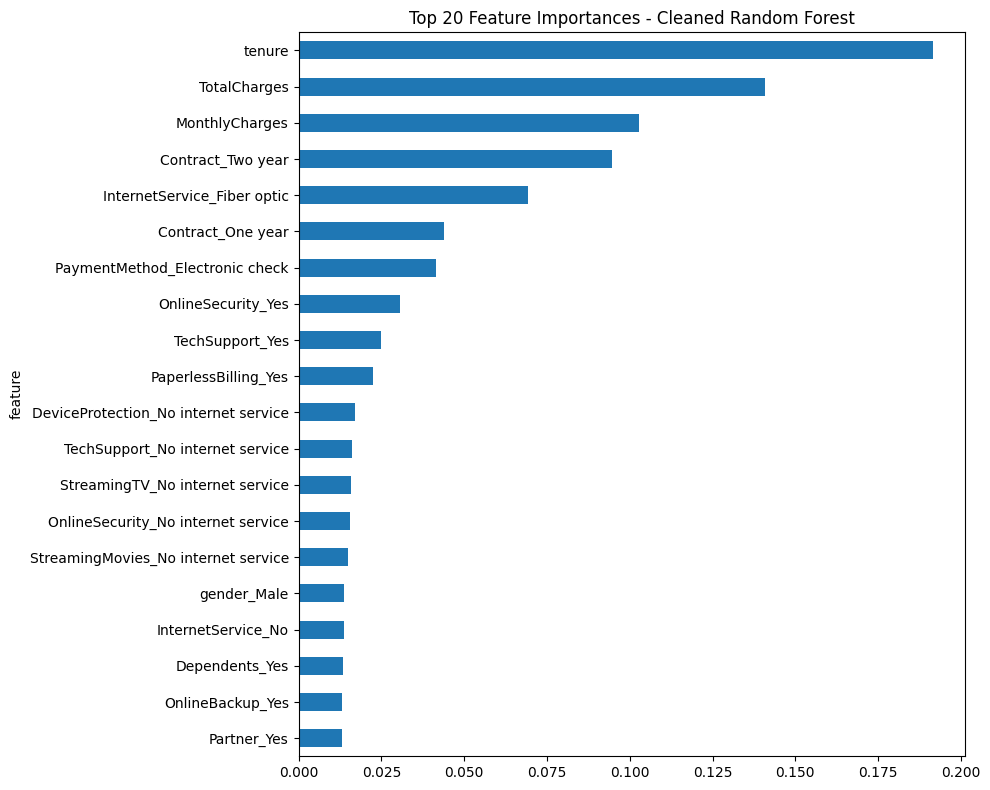

In [64]:

# ---------- PREPROCESAMIENTO INICIAL ----------
# Reemplazar ' ' por '0' y convertir TotalCharges a numérico
X_train['TotalCharges'] = X_train['TotalCharges'].replace(' ', '0')
X_test['TotalCharges'] = X_test['TotalCharges'].replace(' ', '0')
X_train['TotalCharges'] = pd.to_numeric(X_train['TotalCharges'])
X_test['TotalCharges'] = pd.to_numeric(X_test['TotalCharges'])

# ---------- DEFINIR VARIABLES ----------
# Define tus columnas según tu dataset
numeric_cols = ['tenure', 'MonthlyCharges','TotalCharges']
binary_cols = ['Dependents', 'PaperlessBilling', 'SeniorCitizen', 'gender', 'Partner', 'PhoneService'] 
categorical_cols = ['PaymentMethod', 'MultipleLines', 'InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies','Contract']

# ---------- PIPELINE ORIGINAL PARA OBTENER FEATURE IMPORTANCE ----------
preprocessor_full = ColumnTransformer(transformers=[
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_cols),
    ('bin', OneHotEncoder(drop='if_binary'), binary_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='drop')

pipeline_full = Pipeline([
    ('preprocessing', preprocessor_full),
    ('model', RandomForestClassifier(random_state=42))
])

pipeline_full.fit(X_train, y_train)

# ---------- EXTRAER IMPORTANCIAS Y FILTRAR ----------
# Obtener nombres de features después del preprocesamiento
def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        elif hasattr(transformer, 'named_steps'):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                names = last_step.get_feature_names_out(cols)
            else:
                names = cols
        else:
            names = cols
        feature_names.extend(names)
    return feature_names

feature_names = get_feature_names(preprocessor_full)
importances = pipeline_full.named_steps['model'].feature_importances_
importancias_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Filtrar las features importantes
umbral = 0.01
features_a_usar = importancias_df[importancias_df['importance'] >= umbral]['feature'].tolist()

# ---------- NUEVO PIPELINE SOLO CON FEATURES IMPORTANTES ----------
# Usamos el preprocesamiento de antes, pero conservamos solo las columnas importantes
# Creamos un nuevo ColumnTransformer que genere las mismas features
# Pero seleccionaremos solo las importantes después de la transformación

from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer para seleccionar columnas por nombre después de transformación
class FeatureSelectorByName(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names_to_keep):
        self.feature_names_to_keep = feature_names_to_keep

    def fit(self, X, y=None):
        self.columns_ = X.columns if isinstance(X, pd.DataFrame) else np.array(self.feature_names_to_keep)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X[self.feature_names_to_keep]
        else:
            idx = [i for i, name in enumerate(self.columns_) if name in self.feature_names_to_keep]
            return X[:, idx]

# Nuevo pipeline
preprocessor_final = ColumnTransformer(transformers=[
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_cols),
    ('bin', OneHotEncoder(drop='if_binary'), binary_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
], remainder='drop')

pipeline_rf = Pipeline([
    ('preprocessing', preprocessor_final),
    ('model', RandomForestClassifier(random_state=42))
])

# ---------- GRIDSEARCH CON PARÁMETROS ----------
param_grid_rf = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__class_weight': [None, 'balanced']
}

grid_search_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

# ---------- ENTRENAMIENTO FINAL ----------
grid_search_rf.fit(X_train, y_train)

print("✅ Mejores parámetros:", grid_search_rf.best_params_)
print("✅ Mejor recall (CV):", grid_search_rf.best_score_)

# ---------- EVALUACIÓN EN TEST ----------
y_pred_rf = grid_search_rf.predict(X_test)
y_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# ---------- NUEVAS FEATURE IMPORTANCES ----------
mejor_modelo = grid_search_rf.best_estimator_
modelo_rf = mejor_modelo.named_steps['model']
feature_names_final = get_feature_names(mejor_modelo.named_steps['preprocessing'])
importancias_final = modelo_rf.feature_importances_

importancias_df_final = pd.DataFrame({
    'feature': feature_names_final,
    'importance': importancias_final
}).sort_values(by='importance', ascending=False)

print("📊 Importancia de variables (tras limpieza):")
print(importancias_df_final)

# Opcional: gráfico
import matplotlib.pyplot as plt

top_n = 20
importancias_df_final.head(top_n).plot(kind='barh', x='feature', y='importance', figsize=(10, 8), legend=False)
plt.title(f'Top {top_n} Feature Importances - Cleaned Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


El modelo empeora, así que nos quedamos con el inicial, con todas las features